<a href="https://colab.research.google.com/github/zeynep-tkn/PythonProjects/blob/main/Spark_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Veri setini yüklemek

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


PySpark' ı Yükleme ve Oturum Başlatma

In [2]:
# PySpark'ı yükleme
!pip install pyspark

# Gerekli kütüphaneleri içe aktarma
from pyspark.sql import SparkSession

# Spark oturumunu başlatma
spark = SparkSession.builder \
    .appName("Titanic Spark Analysis") \
    .getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=b1fa05cce7c850be04046fdb166f42dc828210491fb70f684c7371cc12832ea1
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


Veri Setini Okuma

In [3]:
#CSV dosyasını okuma
df= spark.read.csv("train.csv",header=True,inferSchema=True)

#Veri çerçevesininin yapısını gösterme
df.printSchema()

#İlk 5 kaydı görüntüleme
df.show()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

#VERİ ANALİZİ
###1.Hayatta Kalma Oranı

In [4]:
# Hayatta kalan ve kalmayan yolcuların sayısını hesaplama
survival_counts = df.groupBy("Survived").count().withColumnRenamed("count", "Passenger Count")
survival_counts.show()

+--------+---------------+
|Survived|Passenger Count|
+--------+---------------+
|       1|            342|
|       0|            549|
+--------+---------------+



In [5]:
# Hayatta kalma oranını hesaplama
total_passengers = df.count()
survival_rate = (survival_counts.filter(survival_counts.Survived == 1).collect()[0][1] / total_passengers) * 100
print(f"Hayatta Kalma Oranı: {survival_rate:.2f}%")

Hayatta Kalma Oranı: 38.38%


In [7]:
# Cinsiyete göre hayatta kalma oranını hesaplama
from pyspark.sql import functions as F

gender_survival = df.groupBy("Sex", "Survived").count().withColumnRenamed("count", "Passenger Count")
gender_survival.show()

# Cinsiyete göre hayatta kalma oranlarını hesaplama
gender_survival_rate = gender_survival.groupBy("Sex").agg(
    F.sum(F.when(F.col("Survived") == 1, 1).otherwise(0)).alias("Survived Count"),
    F.count("*").alias("Total Count")
).withColumn("Survival Rate", (F.col("Survived Count") / F.col("Total Count")) * 100)

gender_survival_rate.show()

+------+--------+---------------+
|   Sex|Survived|Passenger Count|
+------+--------+---------------+
|  male|       0|            468|
|female|       1|            233|
|female|       0|             81|
|  male|       1|            109|
+------+--------+---------------+

+------+--------------+-----------+-------------+
|   Sex|Survived Count|Total Count|Survival Rate|
+------+--------------+-----------+-------------+
|female|             1|          2|         50.0|
|  male|             1|          2|         50.0|
+------+--------------+-----------+-------------+



In [8]:
# Yaşın hayatta kalma oranı üzerindeki etkisi
age_survival = df.groupBy("Age", "Survived").count().groupBy("Age").agg(
    F.sum(F.when(F.col("Survived") == 1, 1).otherwise(0)).alias("Survived Count"),
    F.count("*").alias("Total Count")
).withColumn("Survival Rate", (F.col("Survived Count") / F.col("Total Count")) * 100)

age_survival.show()

+----+--------------+-----------+-------------+
| Age|Survived Count|Total Count|Survival Rate|
+----+--------------+-----------+-------------+
|70.0|             0|          1|          0.0|
| 8.0|             1|          2|         50.0|
| 7.0|             1|          2|         50.0|
|20.5|             0|          1|          0.0|
|49.0|             1|          2|         50.0|
|29.0|             1|          2|         50.0|
|40.5|             0|          1|          0.0|
|64.0|             0|          1|          0.0|
|47.0|             1|          2|         50.0|
|24.5|             0|          1|          0.0|
|42.0|             1|          2|         50.0|
|44.0|             1|          2|         50.0|
|62.0|             1|          2|         50.0|
|NULL|             1|          2|         50.0|
|35.0|             1|          2|         50.0|
|18.0|             1|          2|         50.0|
|80.0|             1|          1|        100.0|
|34.5|             0|          1|       

###Sonuçları Görselleştirme

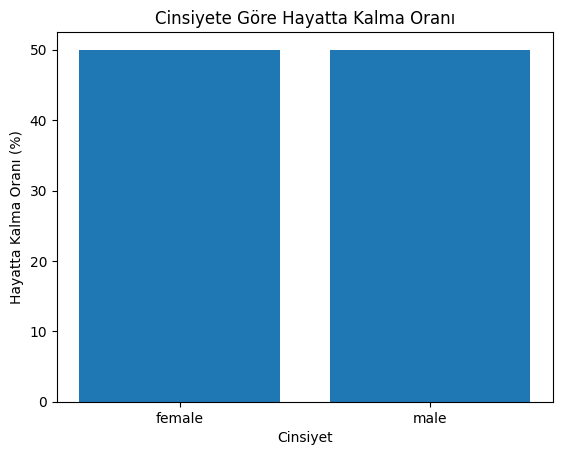

In [9]:
import matplotlib.pyplot as plt

# Cinsiyet hayatta kalma oranını görselleştirme
gender_data = gender_survival_rate.toPandas()

plt.bar(gender_data['Sex'], gender_data['Survival Rate'])
plt.title('Cinsiyete Göre Hayatta Kalma Oranı')
plt.xlabel('Cinsiyet')
plt.ylabel('Hayatta Kalma Oranı (%)')
plt.show()